In [6]:
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

In [7]:
answerDf = pd.read_csv('../data/metadata/answer_metadata_task_3_4.csv', index_col=0)
trainTaskDf = pd.read_csv('../data/train_data/train_task_3_4.csv', index_col=0)
subjectDf = pd.read_csv('../data/metadata/subject_metadata.csv', index_col=0)
questionDf = pd.read_csv('../data/metadata/question_metadata_task_3_4.csv', index_col=0)
studentDf = pd.read_csv('../data/metadata/student_metadata_task_3_4.csv', index_col=0)
qualityDf = pd.read_csv('../data/test_data/quality_response_remapped_public.csv')

In [8]:
confidence = answerDf['Confidence'].to_dict()

In [9]:
trainTaskDf['Confidence'] = trainTaskDf.apply(lambda x: confidence[x['AnswerId']], axis=1)
trainTaskDf['Confidence'].fillna(trainTaskDf['Confidence'].mean(), inplace=True)

In [10]:
QuestionConf = trainTaskDf.groupby(['QuestionId','AnswerValue']).mean()
QuestionAnswer = trainTaskDf.groupby(['QuestionId','AnswerValue']).count()

In [11]:
QuestionConf.reset_index(inplace=True)
QuestionAnswer.reset_index(inplace=True)

In [12]:
QuestionConf = QuestionConf.pivot(index='QuestionId',columns='AnswerValue',values='Confidence')
QuestionAnswer = QuestionAnswer.pivot(index='QuestionId',columns='AnswerValue',values='UserId')
QuestionAnswer.fillna(0, inplace=True)

In [13]:
QuestionConf['mean'] = QuestionConf.mean(axis=1)
QuestionAnswer['Total'] = QuestionAnswer.sum(axis=1)

In [14]:
QuestionConf.rename(columns={1:'Conf1',2:'Conf2',3:'Conf3',4:'Conf4', 'mean':'ConfMean'}, inplace=True)
QuestionAnswer.rename(columns={1:'Answer1',2:'Answer2',3:'Answer3',4:'Answer4', 'Total':'AnswerTotal'}, inplace=True)

In [15]:
def funcSubject(x):
    subjectSet = set()
    d = {'Level1':0,'Level2':0,'Level3':0,'Level0':0}
    subjectIdList = list(map(int, x['SubjectId'].strip('[').strip(']').split(', ')))
    for subject in subjectIdList:
        level = subjectDf.loc[subject, 'Level']
        if subject not in subjectSet:
            subjectSet.add(subject)
            d[f"Level{level}"] += 1
        while (level > 0):
            subject = subjectDf.loc[subject, 'ParentId']
            level = subjectDf.loc[subject, 'Level']
            if subject not in subjectSet:
                subjectSet.add(subject)
                d[f"Level{level}"] += 1
    return pd.Series(d,index=['Level1','Level2','Level3','Level0'])


In [16]:
questionLevelDf = questionDf.apply(funcSubject, axis=1)
questionLevelDf['totalLevel'] = questionLevelDf.sum(axis=1)

Text(0, 0.5, 'Number of questions (log scale)')

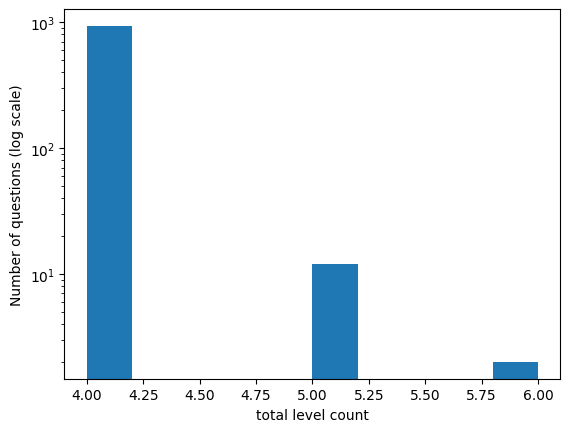

In [17]:
plt.hist(questionLevelDf['totalLevel'],log=True)
plt.xlabel('total level count')
plt.ylabel('Number of questions (log scale)')

In [18]:
dropCol = []
for col in list(qualityDf.columns):
    if 'Unnamed' in col:
        dropCol.append(col)
qualityDf.drop(dropCol, inplace=True, axis=1)

In [19]:
qualityDf = qualityDf.astype(int)

In [20]:
qualityDict = {}
for i, row in qualityDf.iterrows():
    lScore = list(row[2:]).count(1) / 5
    rScore = 1 - lScore
    if int(row['left']) in qualityDict:
        print(int(row['left']))
    qualityDict[int(row['left'])] = round(lScore, 2)
    qualityDict[int(row['right'])] = round(rScore, 2)


527


In [21]:
questionDf['Score'] = [np.nan] * len(questionDf)

In [22]:
for key, value in qualityDict.items():
    questionDf.loc[key,'Score'] = value

In [23]:
questionJoined = pd.concat([questionDf, QuestionConf, QuestionAnswer, questionLevelDf], axis=1)

In [24]:
questionJoined[questionJoined['Score'].isna() != True]

,SubjectId,Score,Conf1,Conf2,Conf3,Conf4,ConfMean,Answer1,Answer2,Answer3,Answer4,AnswerTotal,Level1,Level2,Level3,Level0,totalLevel
QuestionId,,,,,,,,,,,,,,,,,
202,"[3, 71, 98, 209]",0.2,80.857545,71.061499,72.363385,70.973682,73.814028,1735.0,212.0,151.0,133.0,2231.0,1,1,1,1,4
403,"[3, 71, 98, 209]",0.2,69.618957,71.719632,78.212962,71.194668,72.686555,214.0,309.0,1437.0,243.0,2203.0,1,1,1,1,4
691,"[3, 71, 98, 209]",0.4,69.548452,69.636572,75.118109,69.780064,71.020799,194.0,338.0,1432.0,220.0,2184.0,1,1,1,1,4
830,"[3, 32, 144, 204]",0.8,68.849548,72.914987,72.825217,75.602347,72.548025,454.0,393.0,321.0,1231.0,2399.0,1,1,1,1,4
285,"[3, 32, 144, 204]",0.0,69.393231,75.768238,66.893546,69.262289,70.329326,444.0,1538.0,231.0,148.0,2361.0,1,1,1,1,4
233,"[3, 32, 33, 144]",0.8,70.628627,69.425021,74.105185,66.270449,70.107321,250.0,738.0,1277.0,341.0,2606.0,1,1,1,1,4
547,"[3, 32, 42, 211]",1.0,70.323470,72.454912,73.136035,77.470400,73.346204,127.0,628.0,657.0,1512.0,2924.0,1,1,1,1,4
676,"[3, 32, 42, 211]",0.8,76.054851,69.909226,69.560378,70.852035,71.594123,1661.0,515.0,356.0,346.0,2878.0,1,1,1,1,4
527,"[3, 32, 42, 211]",0.0,73.168617,77.655402,72.109336,73.945507,74.219716,300.0,1903.0,205.0,255.0,2663.0,1,1,1,1,4
